# 1. Problem Statement

For a student graduating high school in India, planning for admission in the top colleges in the United States can be a nerve-wracking experience. Jamboree Education has helped thousands of students sail through this process with a data-driven appraoch. They recently launched a feature where students can come to their website and check their probability of getting into the Ivy League college. This feature estimates the chances of graduate admission from an Indian perspective.

The data forecasting performed in this exercise uses Linear Regression models to determine what factors are most important in graduate admissions and how these factors are interrelated amongst themselves. It will also help predict one's chances of admission given the rest of the variables.

_____
# 2. Data Loading & Preprocessing

In [140]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from IPython.display import display, Math, Markdown
from itertools import combinations

from scipy.stats import chi2_contingency

import statsmodels.api as sm
from statsmodels.api import OLS
from statsmodels.formula.api import ols
from statsmodels.stats.anova import anova_lm
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## **Data Dictionary**

<small>

|Feature|Description|
|---|---|
|Serial No.|This column represents the unique row identifier for each applicant in the dataset.|
|GRE Scores|This column contains the GRE (Graduate Record Examination) scores of the applicants, which are measured on a scale of 0 to 340.|
|TOEFL Scores|This column includes the TOEFL (Test of English as a Foreign Language) scores of the applicants, which are measured on a scale of 0 to 120.|
|University Rating|This column indicates the rating or reputation of the university that the applicants are associated with. The rating is based on a scale of 0 to 5, with 5 representing the highest rating.|
|SOP|This column represents the strength of the applicant's statement of purpose, rated on a scale of 0 to 5, with 5 indicating a strong and compelling SOP.|
|LOR|This column represents the strength of the applicant's letter of recommendation, rated on a scale of 0 to 5, with 5 indicating a strong and compelling LOR.|
|CGPA|This column contains the undergraduate Grade Point Average (GPA) of the applicants, which is measured on a scale of 0 to 10.|
|Research|This column indicates whether the applicant has research experience (1) or not (0).|
|Chance of Admit|This column represents the estimated probability or chance of admission for each applicant, ranging from 0 to 1.|

</small>

In [141]:
df = pd.read_csv("jamboree_dataset.csv")
display(df)

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65
...,...,...,...,...,...,...,...,...,...
495,496,332,108,5,4.5,4.0,9.02,1,0.87
496,497,337,117,5,5.0,5.0,9.87,1,0.96
497,498,330,120,5,4.5,5.0,9.56,1,0.93
498,499,312,103,4,4.0,5.0,8.43,0,0.73


In [142]:
print("*** Dataset Info ***")
display(df.info())

print("*** Null Values ***")
display(df.isnull().sum())

*** Dataset Info ***
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Serial No.         500 non-null    int64  
 1   GRE Score          500 non-null    int64  
 2   TOEFL Score        500 non-null    int64  
 3   University Rating  500 non-null    int64  
 4   SOP                500 non-null    float64
 5   LOR                500 non-null    float64
 6   CGPA               500 non-null    float64
 7   Research           500 non-null    int64  
 8   Chance of Admit    500 non-null    float64
dtypes: float64(4), int64(5)
memory usage: 35.3 KB


None

*** Null Values ***


Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

<u>**Observations**</u>

- The given dataset contains 500 rows and 9 columns.

- None of the columns have null values. 

- `Serial No.` can be dropped as it is not informing the analysis in any way.

- Remaining columns will be renamed for convenience.

In [143]:
df = df.drop(['Serial No.'], axis=1)
df.columns = ['gre_score', 
              'toefl_score', 
              'university_rating', 
              'statement_of_purpose',
              'letter_of_recommendation', 
              'cgpa_score', 
              'research', 
              'chance_of_admit']

df.describe().loc[['min', 'mean', 'max']]

,gre_score,toefl_score,university_rating,statement_of_purpose,letter_of_recommendation,cgpa_score,research,chance_of_admit
min,290.000,92.000,1.000,1.000,1.000,6.80000,0.00,0.34000
mean,316.472,107.192,3.114,3.374,3.484,8.57644,0.56,0.72174
max,340.000,120.000,5.000,5.000,5.000,9.92000,1.00,0.97000


## **Declare features and target variable**

|column|type|min|max|comment|
|---|---|---|---|---|
|`gre_score`|int|290|340|feature|
|`toefl_score`|int|92|120|feature|
|`university_rating`|int|1|5|feature|
|`statement_of_purpose`|float|1.0|5.0|feature|
|`letter_of_recommendation`|float|1.0|5.0|feature|
|`cgpa_score`|float|6.80|9.92|feature|
|`research`|int|0|1|feature|
|`chance_of_admit`|float|0.34|0.97|target|

In [144]:
target_variable       =  'chance_of_admit'
numerical_variables   = ['gre_score', 
                         'toefl_score', 
                         'cgpa_score']
categorical_variables = ['university_rating', 
                         'letter_of_recommendation', 
                         'statement_of_purpose',
                         'research']

# Target variable (Series)
y = df[target_variable]

# Predictor variables (Dataframe)
X = df.loc[:, df.columns != target_variable]

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.reset_index(drop=True, inplace=True)
X_test.reset_index(drop=True, inplace=True)
y_train.reset_index(drop=True, inplace=True)
y_test.reset_index(drop=True, inplace=True)

_____
# 3. Exploratory Data Analysis (EDA)

## **Univariate Analysis**

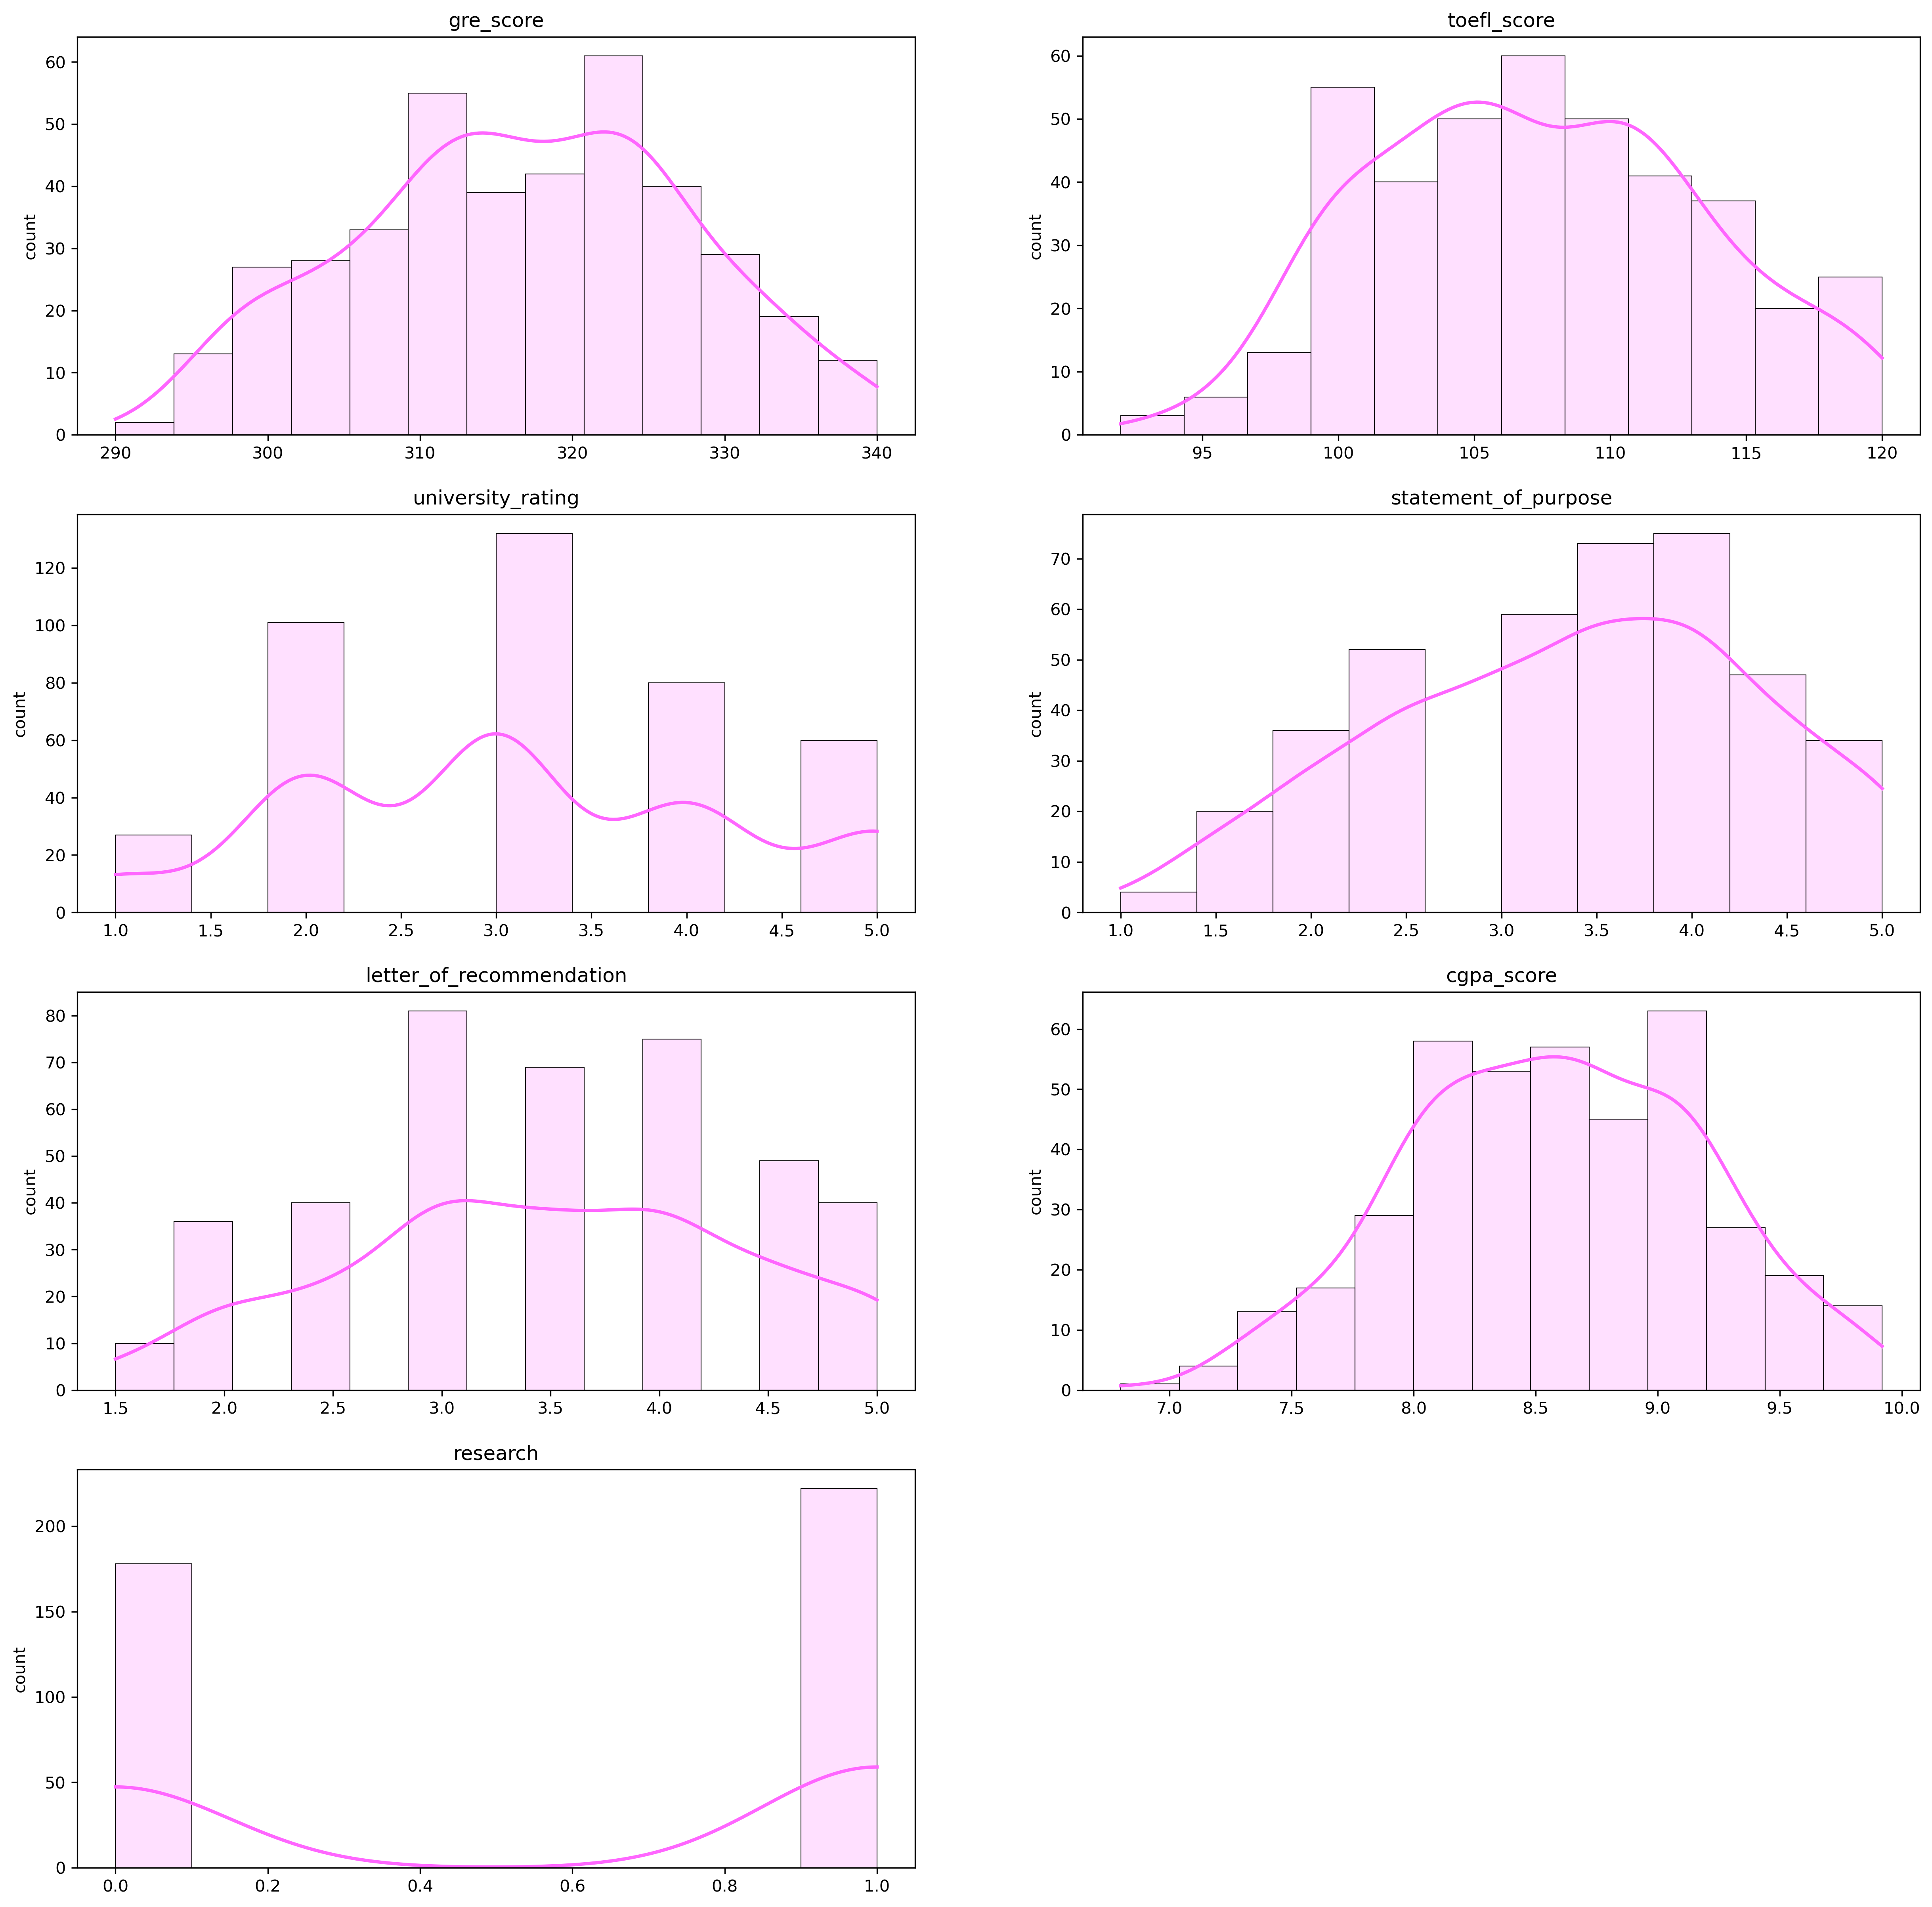

In [145]:
# Univariate analysis
n_features = len(X_train.columns)
n_rows, n_cols = 4, 2
fig, ax = plt.subplots(n_rows, n_cols, figsize=(20, 20), dpi=300)
ax = ax.flatten()

for i, column in enumerate(X.columns):
    sns.histplot(X_train[column], 
                edgecolor="black", 
                linewidth=0.5, 
                alpha=0.2, 
                kde=True, 
                color="#FF66FF", 
                line_kws={"color": "#FF33FF", "lw": 2}, 
                stat="count",
                ax=ax[i])
    ax[i].set_xlabel(None)
    ax[i].set_ylabel("count")
    ax[i].set_title(column)

# Hide any unused subplots
for j in range(n_features, n_rows * n_cols):
    ax[j].axis('off')

plt.show()

<u>**Observations**</u>

The plots of scores (`gre_score`, `toefl_score` and `cgpa_score`) show that students are (roughly) normally distributed across the performance spectrum.

Other variables (`university_rating`, `statement_of_purpose`, `letter_of_recommendation`, `research`) are categorical variables and need to be treated differently from the numerical variables.

## **Bivariate Analysis: Continuous Variables vs Target**

`gre_score`, `toefl_score`, `cgpa_score`

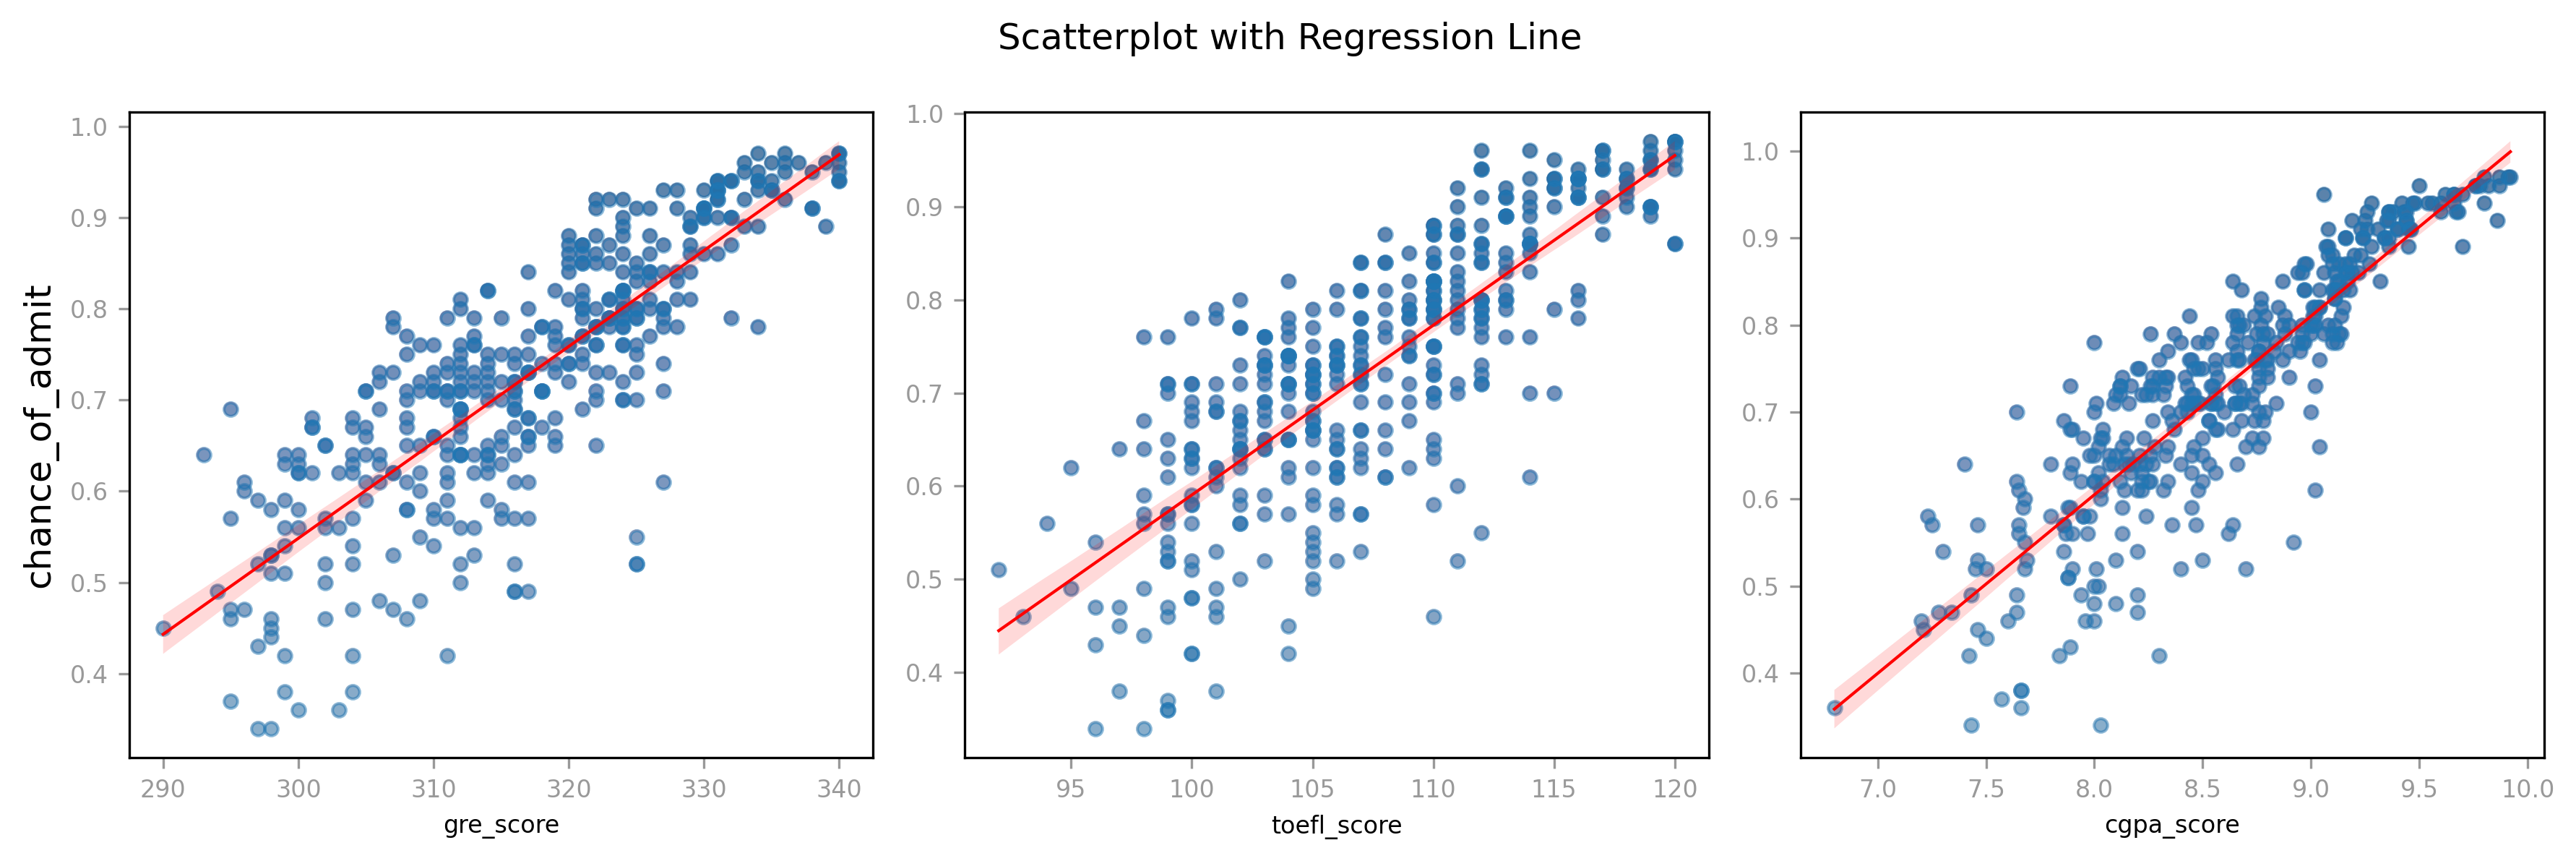

In [146]:
def scatterplot(x, y, ax=None):
    sns.scatterplot(ax=ax,
                    x=x,
                    y=y,
                    hue=y,
                    s=20,
                    alpha=0.5,
                    color='#FF66FF',
                    marker='o',
                    edgecolor=None,
                    legend=False)
    sns.regplot(x=x, y=y, ax=ax, 
                scatter_kws={'s': 20, 'alpha': 0.5}, 
                line_kws={'color': 'red', 'lw': 1.0})

fig, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=300)
plt.suptitle("Scatterplot with Regression Line")

for i, var in enumerate(numerical_variables):
    scatterplot(x=X_train[var], y=y_train, ax=axes[i])

for ax in axes.flat:
    ax.tick_params(axis='x', labelsize=8, colors='#999999')
    ax.tick_params(axis='y', labelsize=8, colors='#999999')
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel("", fontsize=8)

axes[0].set_ylabel("chance_of_admit", fontsize=12)
plt.tight_layout()
plt.show()

<u>**Observations**</u>

* All three features (`gre_score`, `toefl_score`, `cgpa_score`) show a strong positive linear relationship with `chance_of_admit`.

* Regression lines fit the data well, indicating linearity.

* Data points are tightly clustered around the regression line, especially for `cgpa_score`, suggesting high predictive power.

* Some spread and mild heteroscedasticity visible, but no major outliers or nonlinear patterns.

## **Bivariate Analysis: Categorical Variables vs Target**

`university_rating`, `letter_of_recommendation`, `statement_of_purpose`, `research`

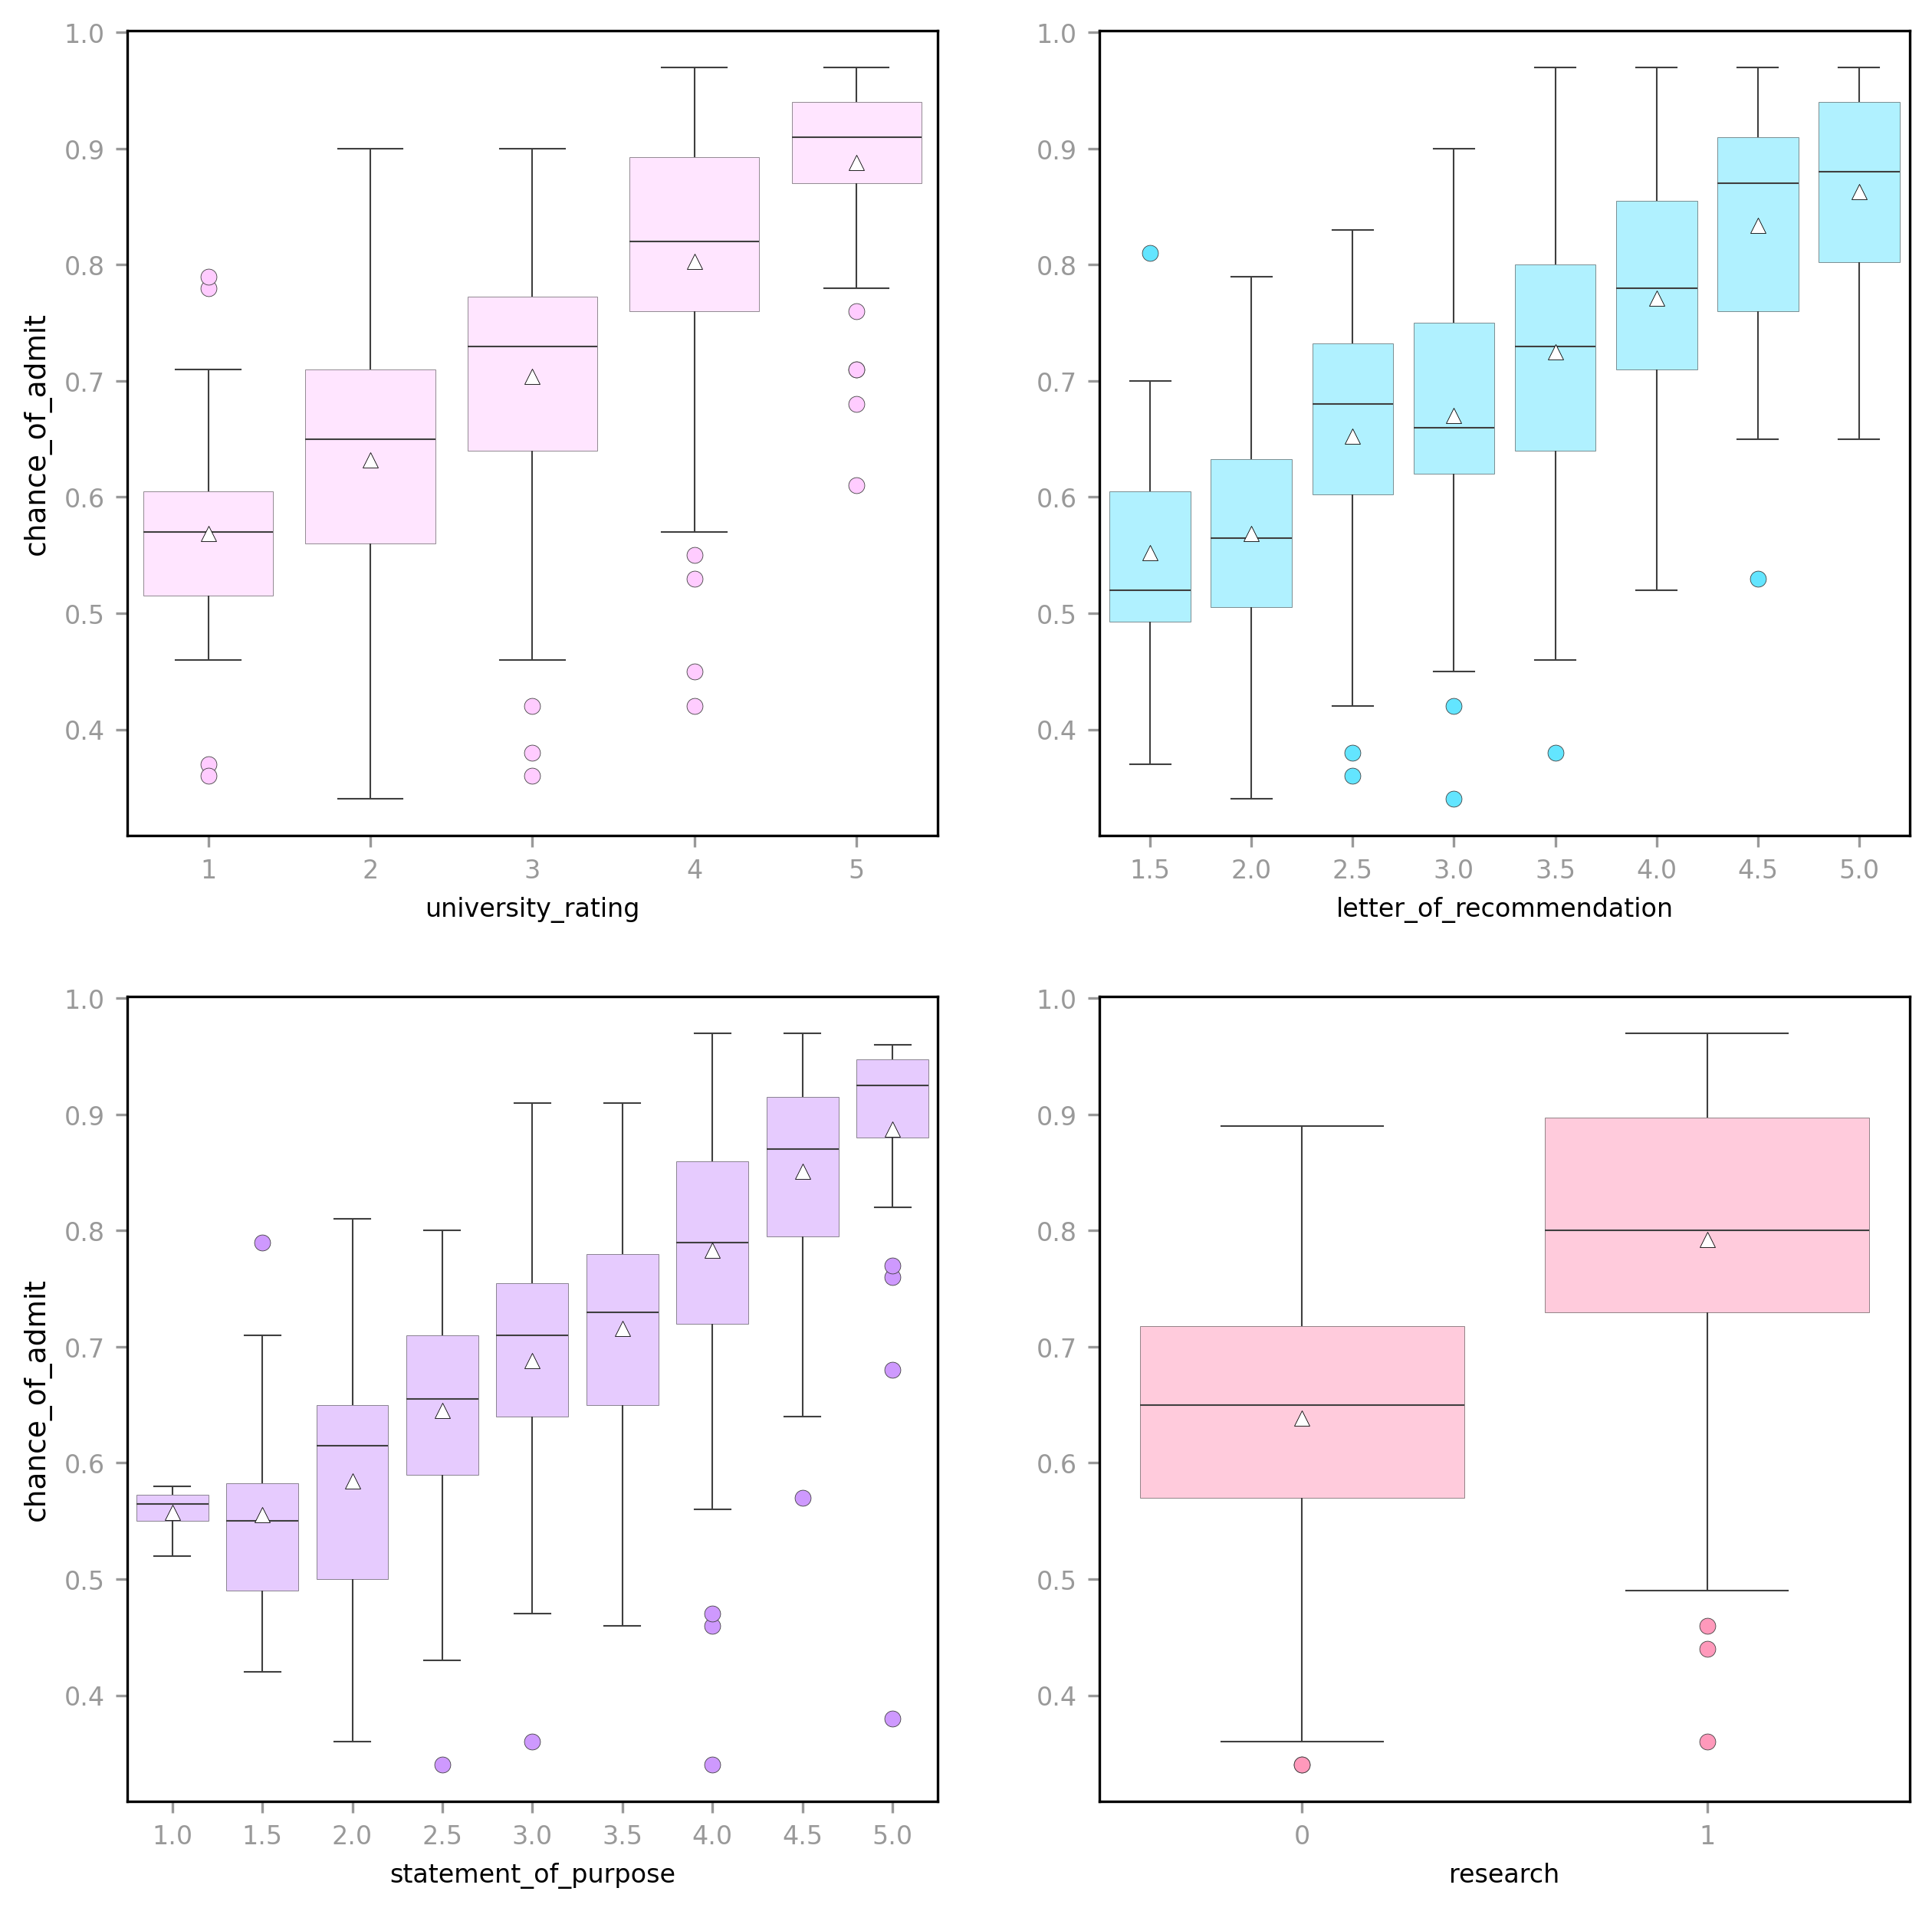

In [147]:
def boxplot(x, y, color="lightblue", ax=None):
    sns.boxplot(ax=ax,
                x=x,
                y=y,
                linewidth=0.5,
                showmeans=True,
                boxprops={   'facecolor':color, 
                             'edgecolor':'black', 
                             'linewidth':0.2, 
                             'alpha':0.5},
                meanprops={  'markerfacecolor':'white', 
                             'markeredgecolor':'black', 
                             'marker':'^', 
                             'markeredgewidth':0.2, 
                             'markersize':5}, 
                flierprops={ 'marker':'o', 
                             'markerfacecolor':color, 
                             'markersize':5, 
                             'markeredgewidth':0.2},
                legend=False)

fig, axes = plt.subplots(2, 2, figsize=(10, 10), dpi=300)

axes = axes.flatten()
colour_sequence = ['#FFCCFF', '#63E5FF', '#CE99FE', '#FF99BB']

for i, var in enumerate(categorical_variables):
    boxplot(x=X_train[var], y=y_train, color=colour_sequence[i], ax=axes[i])

for ax in axes.flat:
    ax.tick_params(axis='x', labelsize=8, colors='#999999')
    ax.tick_params(axis='y', labelsize=8, colors='#999999')
    ax.set_xlabel(ax.get_xlabel(), fontsize=8)
    ax.set_ylabel("", fontsize=8)

axes[0].set_ylabel("chance_of_admit", fontsize=9)
axes[2].set_ylabel("chance_of_admit", fontsize=9)

plt.show()

<u>**Observations**</u>

* Higher `university_rating`, `letter_of_recommendation`, and `statement_of_purpose` scores are associated with higher median `chance_of_admit`.

* All three show a clear upward trend, though with some overlap and outliers at each level.

* Applicants with research experience (1) have a higher median and less spread in `chance_of_admit` compared to those without (0).

* Distributions are generally symmetric, but mild outliers are present at lower admit chances for all categories.

## **Multivariate analysis**

### *Correlation Matrix of Numerical Predictors and Target*

,gre_score,toefl_score,cgpa_score,chance_of_admit
gre_score,1.00,0.82,0.82,0.82
toefl_score,0.82,1.00,0.80,0.79
cgpa_score,0.82,0.80,1.00,0.88
chance_of_admit,0.82,0.79,0.88,1.00


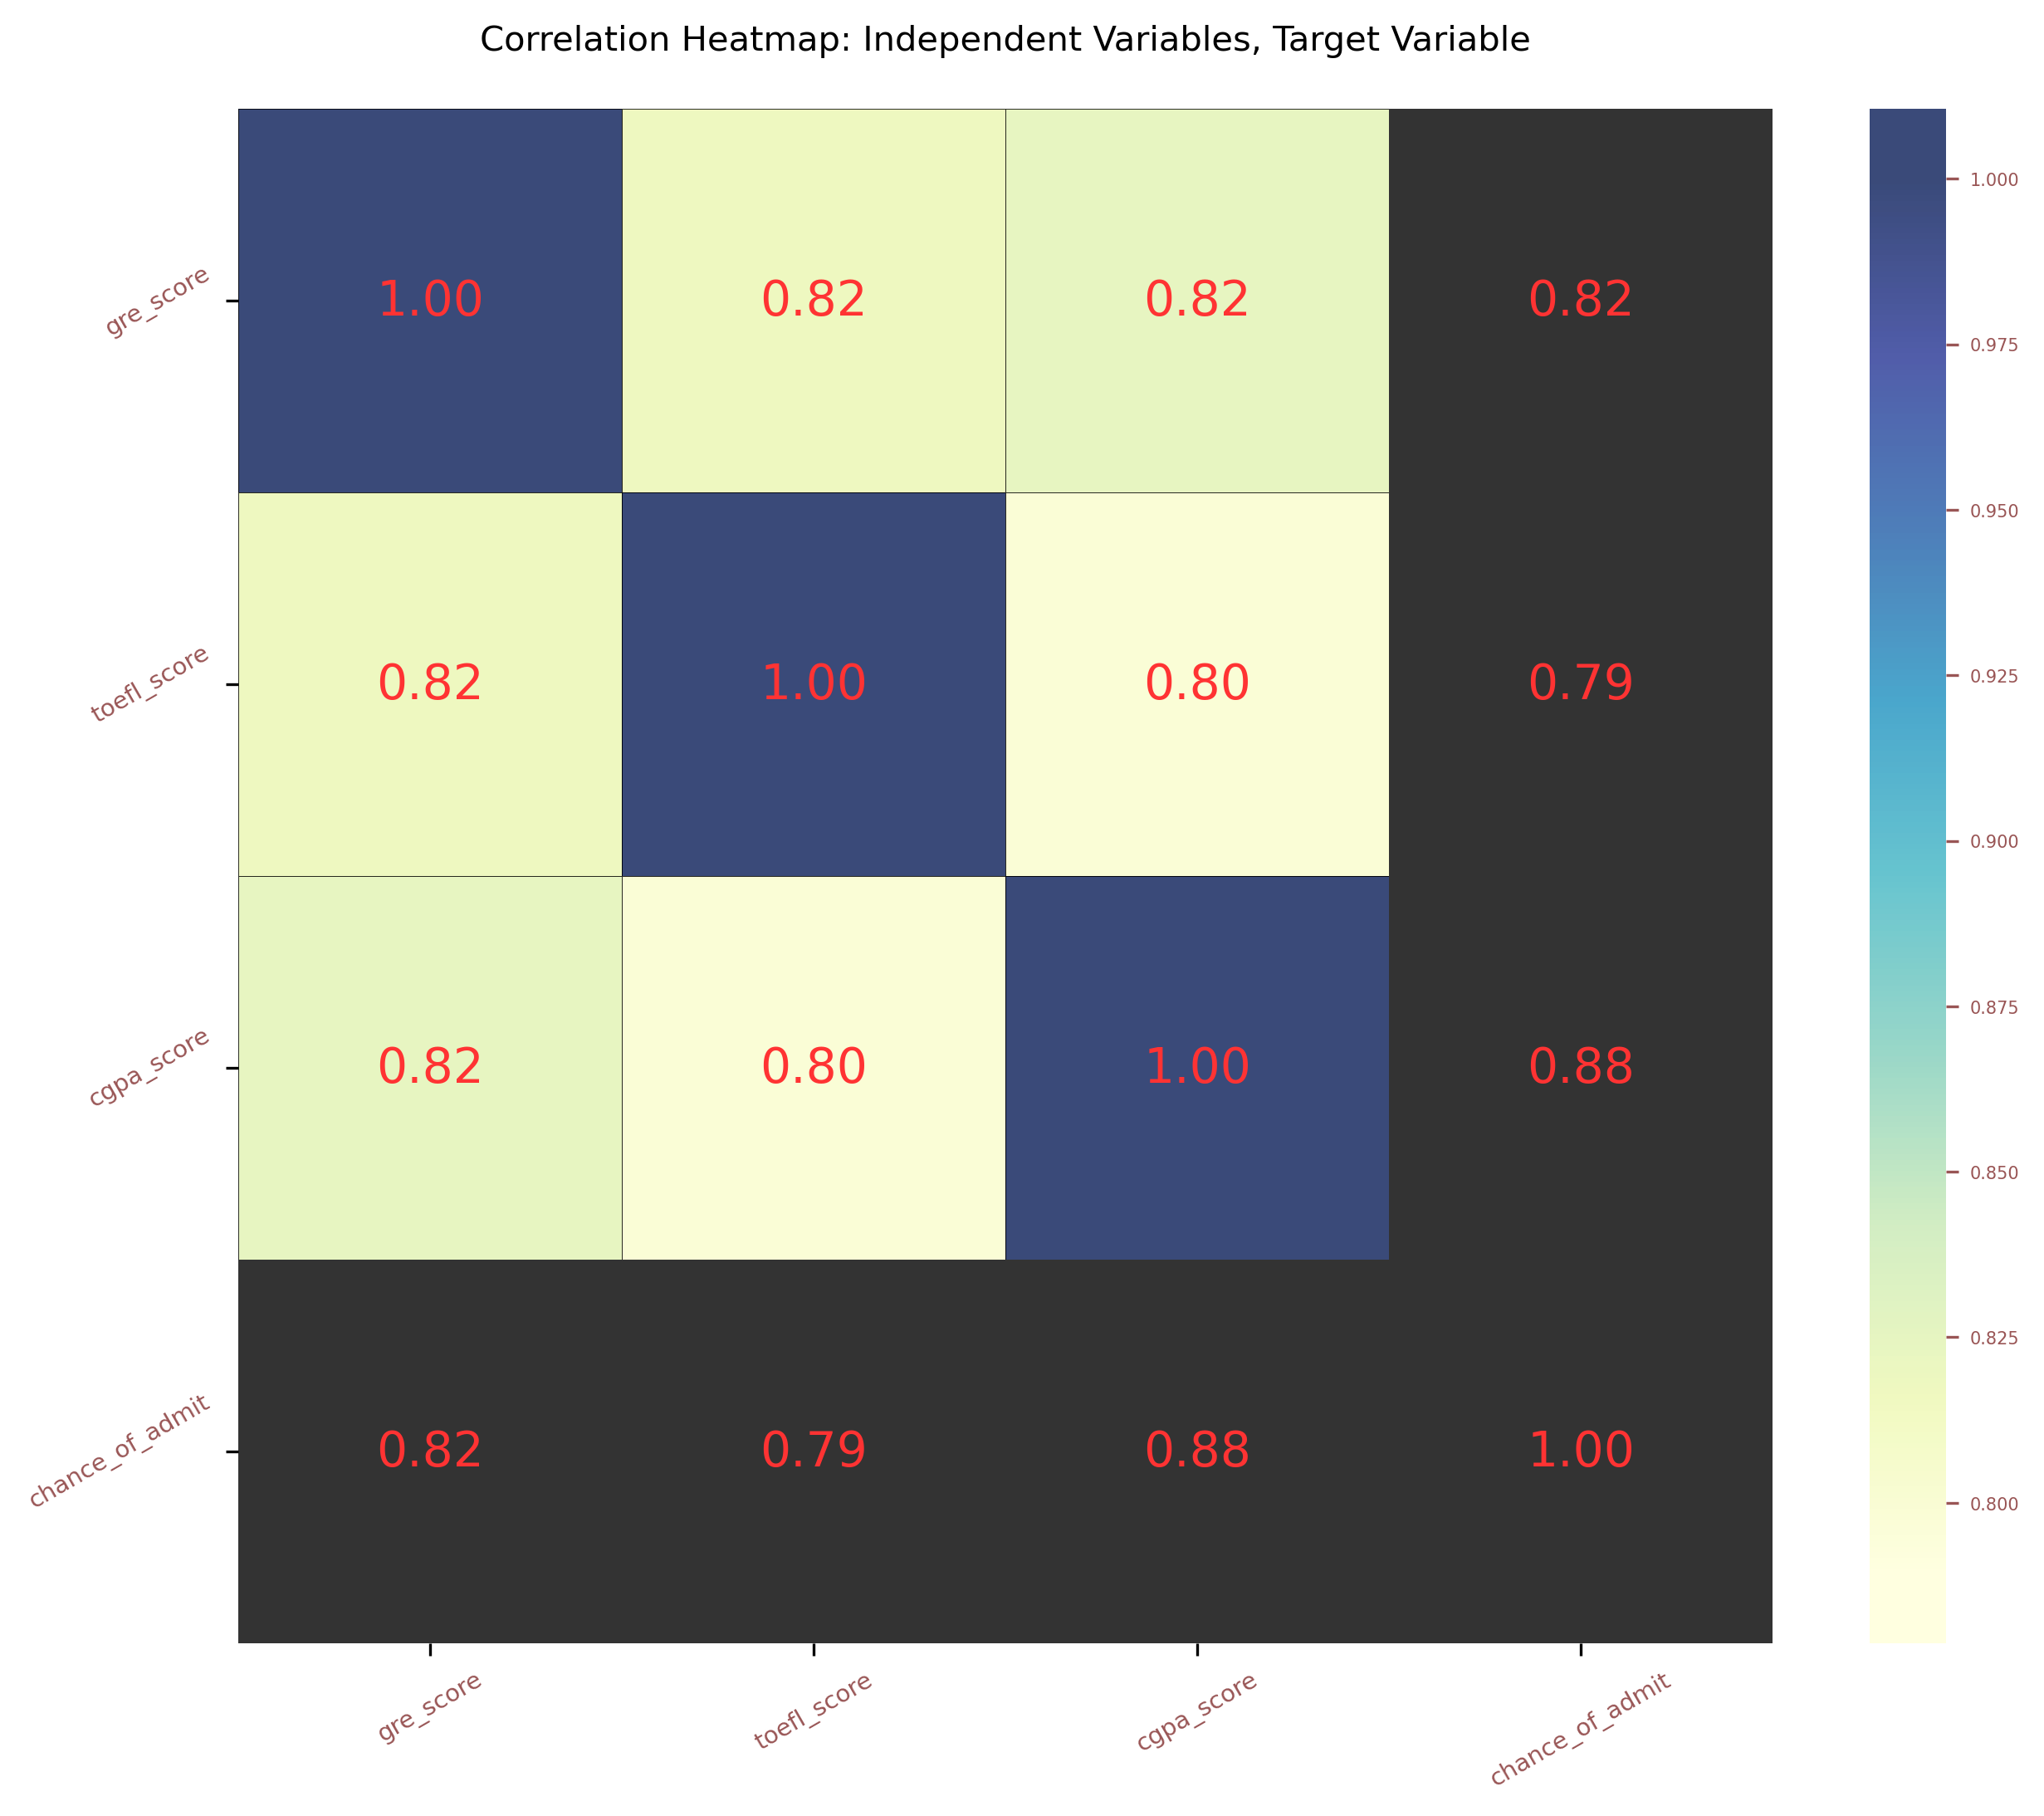

In [148]:
# Complete Correlations Matrix with numerical features and target variable
corr_matrix = pd.concat([X_train, y_train], axis=1)[numerical_variables+['chance_of_admit']].corr()

vmin = corr_matrix.min().min()
vmax = 1.0
center = vmin + (vmax - vmin)/2

plt.figure(figsize=(10, 8), dpi=300)
ax = sns.heatmap(
        corr_matrix,
        annot=True,
        fmt=".2f",
        linecolor='black',
        linewidths=0.2,
        square=True,
        alpha=0.8,
        mask=None,
        annot_kws={"size": 14, "color": '#ff3333'},
        vmin=vmin,
        center=center,
        vmax=vmax,
        cmap='YlGnBu',
        cbar_kws={"shrink": 1.0, "extend": "both", "extendfrac": 0.05, "extendrect": True})

target_idx = corr_matrix.columns.get_loc(y.name)

ax.add_patch(
    patches.Rectangle(
        (0, target_idx), len(corr_matrix.columns), 1,
        fill=True, color='#333333', alpha=1.0, lw=0))
ax.add_patch(
    patches.Rectangle(
        (target_idx, 0), 1, len(corr_matrix.columns),
        fill=True, color='#333333', alpha=1.0, lw=0))

plt.title("Correlation Heatmap: Independent Variables, Target Variable\n", fontsize=10)
plt.xticks(fontsize=7, rotation=30, color='#995555')
plt.yticks(fontsize=7, rotation=30, color='#995555')
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=5, colors='#995555')

display(round(corr_matrix, 2))

plt.show()

<u>**Observations**</u>

- All correlations are in the positive direction.

- The three continuous predictors (`gre_score`, `toefl_score`, `cgpa_score`) are very highly correlated amongst themselves (0.80 ~ 0.82).

- Each of these features shows a strong positive correlation (0.79 ~ 0.88) with the target variable `chance_of_admit`.

- This suggests that as students' scores increase, their chances of admission also increases.

    🛑 high intercorrelations might also indicate potential multicollinearity.

### *Cramer's V Table for Categorical Variables*

In [149]:
def cramers_v(confusion_matrix):
    chi2, p, dof, expected = chi2_contingency(confusion_matrix)
    n = confusion_matrix.sum()
    min_dim = min(confusion_matrix.shape) - 1
    return np.sqrt(chi2 / (n * min_dim))

# Compute Cramer's V between categorical variables
print("*** Cramer's V Table ***")
cramers_v_table = []
for var1, var2 in combinations(categorical_variables, 2):
    contingency = pd.crosstab(X_train[var1], X_train[var2])
    v = cramers_v(contingency.values)
    cramers_v_table.append(f"V = {v:.4f} (`{var1}` vs `{var2}`)")

cramers_v_table.sort(reverse=True)
cramers_v_table = "\n\n".join(cramers_v_table)
display(Markdown(cramers_v_table))


*** Cramer's V Table ***


V = 0.4763 (`university_rating` vs `statement_of_purpose`)

V = 0.4569 (`university_rating` vs `research`)

V = 0.4084 (`statement_of_purpose` vs `research`)

V = 0.3532 (`university_rating` vs `letter_of_recommendation`)

V = 0.3328 (`letter_of_recommendation` vs `research`)

V = 0.3137 (`letter_of_recommendation` vs `statement_of_purpose`)

<u>**Observations**</u>

- Cramer’s V values range from about 0.31 to 0.48.

- The highest value (0.4763) is between `university_rating` and `statement_of_purpose`, suggesting a moderate association between the two.

- Values around 0.33 ~ 0.45 suggest moderate relationships among the categorical predictors, indicating they share some common variance but are not redundant.

### *Effect Sizes for Categorical Variables vs. Target*

In [150]:
eta_squared_results = []

for var in categorical_variables:
    # Perform ANOVA for each categorical variable
    model = ols(f'chance_of_admit ~ C({var})', data=df).fit()
    anova_results = anova_lm(model)

    # Extract the sum of squares for the effect and residuals
    ss_effect = anova_results.loc[f'C({var})', 'sum_sq']
    ss_total = ss_effect + anova_results.loc['Residual', 'sum_sq']

    eta_squared = ss_effect / ss_total
    eta_squared_results.append(f"η² = {eta_squared:.4f} (`{var}`)")

print("*** Eta Squared Table ***")
eta_squared_results.sort(reverse=True)
eta_squared_results = "\n\n".join(eta_squared_results)
display(Markdown(f"\n\n{eta_squared_results}"))

*** Eta Squared Table ***




η² = 0.4795 (`university_rating`)

η² = 0.4770 (`statement_of_purpose`)

η² = 0.4206 (`letter_of_recommendation`)

η² = 0.2980 (`research`)

<u>**Observations**</u>

- η² values indicate the proportion of variance in `chance_of_admit` explained by each categorical predictor.

- `university_rating` and `statement_of_purpose` each account for a substantial 48% of variance. These have the strongest association with `chance_of_admit`.

- `letter_of_recommendation` and `research` explain about 42% and 30% of the variance respectively.

_____
# 4. Model Building: OLS Linear Regression

* Note to Self –

    - Comment on R-squared and Adjusted R-squared (goodness of fit).

    - Analyze F-statistic and its p-value (overall model significance).

    - Examine coefficients (slope) for each predictor variable, along with their p-values.

    - Display model coefficients with column names explicitly.

    - Interpret the meaning of each significant coefficient in the context of the problem.

In [151]:
# Apply feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test, columns=X.columns)

# Add a constant term for the intercept
X_train = sm.add_constant(X_train)
X_test  = sm.add_constant(X_test)

display(X_train.head())

,const,gre_score,toefl_score,university_rating,statement_of_purpose,letter_of_recommendation,cgpa_score,research
0,1.0,0.389986,0.602418,-0.098298,0.126796,0.564984,0.415018,0.895434
1,1.0,-0.066405,0.602418,0.775459,0.633979,1.651491,-0.067852,-1.116777
2,1.0,-1.253022,-0.876917,-0.098298,0.126796,-0.521524,-0.134454,-1.116777
3,1.0,-0.248961,-0.055064,-0.972054,-0.887570,0.564984,-0.517420,-1.116777
4,1.0,-0.796631,-0.219435,-0.098298,0.126796,-1.064777,-0.617324,0.895434


## `model1`: *All Inclusive*

• Uses every predictor

• Achieves the highest R² (0.8211) but includes predictors with relatively small coefficients

• F-statistic is 257.0, indicating overall model significance.

In [152]:
def equation_of_line(coefs: list, intercept: float, features: list) -> Math:
    terms = [f"({coefs[i]:.4f}*{features[i].replace('_', '–')})" for i in range(len(coefs))]
    terms = terms[1:] if 'const' in terms[0] else terms
    terms = sorted(terms, reverse=True)
    terms = "+".join(terms)
    equation = f"y = {intercept:.4f} + {terms}"
    return Math(equation)

ols_model_params = lambda model: (model.params.values.tolist(), model.params.iloc[0])

model1 = sm.OLS(y_train, X_train).fit()
coefs, intercept = ols_model_params(model1)

display(Math(f"R^2: {model1.rsquared:.4f}"))
display(equation_of_line(coefs, intercept, X_train.columns.tolist()))
display(model1.summary())

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        chance_of_admit   R-squared:                       0.821
Model:                            OLS   Adj. R-squared:                  0.818
Method:                 Least Squares   F-statistic:                     257.0
Date:                Mon, 16 Jun 2025   Prob (F-statistic):          3.41e-142
Time:                        03:10:05   Log-Likelihood:                 561.91
No. Observations:                 400   AIC:                            -1108.
Df Residuals:                     392   BIC:                            -1076.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.7242      0.003    241.441      0.000       0.718       0.730
gre_score                    0.0267      0.006      4.196      0.000       0.014       0.039
toefl_score                  0.0182      0.006      3.174      0.002       0.007       0.030
university_rating            0.0029      0.005      0.611      0.541      -0.007       0.012
statement_of_purpose         0.0018      0.005      0.357      0.721      -0.008       0.012
letter_of_recommendation     0.0159      0.004      3.761      0.000       0.008       0.024
cgpa_score                   0.0676      0.006     10.444      0.000       0.055       0.080
research                     0.0119      0.004      3.231      0.001       0.005       0.019
==============================================================================
Omnibus:                       86.232   Durbin-Watson:                   2.050
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              190.099
Skew:                          -1.107   Prob(JB):                     5.25e-42
Kurtosis:                       5.551   Cond. No.                         5.65
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<u>**Observations**</u>

* 82.1% (R² = 0.821) of the variance in the target variable is explained by the model.

* Overfitting not a concern as Adjusted R² (0.818) is very close to R².

* Model is statistically significant overall indicated by F-statistic (257.0) and p-value ≈ 0 

* Highly significant Variables (p < 0.01):

    - `cgpa_score` (coef: 0.0676 - strongest positive impact)

    - `gre_score` (coef: 0.0267)
    
    - `toefl_score` (coef: 0.0182)

    - `letter_of_recommendation` (coef: 0.0159)

    - `research` (coef: 0.0119)

_____
# 5. Feature Elimination & Selection

Using observations from the Correlations Matrix and OLS Model Summary, we proceed to systematically eliminate features due to collinearity and/or low significance.

In [153]:
def vif_table(X, remove=None):

    # Remove specified columns if provided
    if remove:
        X = X.drop(remove, axis=1)

    # Ensure constant is added for VIF calculation
    if 'const' not in X.columns:
        X = sm.add_constant(X)

    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif_data.T

display(vif_table(X_train))
display(vif_table(X_train, remove=['university_rating']))
display(vif_table(X_train, remove=['university_rating', 
                                   'statement_of_purpose']))

,0,1,2,3,4,5,6,7
feature,const,gre_score,toefl_score,university_rating,statement_of_purpose,letter_of_recommendation,cgpa_score,research
VIF,1.0,4.489983,3.664298,2.57211,2.785764,1.977698,4.65454,1.518065


,0,1,2,3,4,5,6
feature,const,gre_score,toefl_score,statement_of_purpose,letter_of_recommendation,cgpa_score,research
VIF,1.0,4.471988,3.629404,2.466851,1.929988,4.578632,1.507689


,0,1,2,3,4,5
feature,const,gre_score,toefl_score,letter_of_recommendation,cgpa_score,research
VIF,1.0,4.471557,3.540082,1.655867,4.281365,1.50467


<u>**Observations**</u>

* All VIF values are well below a reasonable threshold of 5. 

* This indicates that multicollinearity is low and not a concern in the feature set.

* We can safely keep all features from a multicollinearity perspective. However, we should still consider feature selection for model optimization.

## `model2`: *La Parsimoniosa*

• Only includes `cgpa_score` and `gre_score`

• R² drops slightly to 0.8003 but model explains as much as 80% of the variance with only two predictors.

• The much higher F-statistic (795.4) suggests stronger overall significance given the small number of predictors, enhancing interpretability and reducing potential multicollinearity.

In [154]:
parsimonious_set = ['const', 'cgpa_score', 'gre_score']
x_train = X_train[parsimonious_set]

model2 = sm.OLS(y_train, x_train).fit()
coefs, intercept = ols_model_params(model2)

display(Math(f"\large R^2: {model2.rsquared:.4f}"))
display(equation_of_line(coefs, intercept, parsimonious_set))
display(model2.summary())

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        chance_of_admit   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     795.4
Date:                Mon, 16 Jun 2025   Prob (F-statistic):          1.35e-139
Time:                        03:10:05   Log-Likelihood:                 539.94
No. Observations:                 400   AIC:                            -1074.
Df Residuals:                     397   BIC:                            -1062.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.7242      0.003    229.987      0.000       0.718       0.730
cgpa_score     0.0884      0.006     15.892      0.000       0.077       0.099
gre_score      0.0424      0.006      7.621      0.000       0.031       0.053
==============================================================================
Omnibus:                       81.887   Durbin-Watson:                   2.013
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              174.190
Skew:                          -1.068   Prob(JB):                     1.50e-38
Kurtosis:                       5.426   Cond. No.                         3.22
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## `model3` *Keep Some, Lose Some*

• Retains `cgpa_score`, `gre_score`, `letter_of_recommendation` and `research`

• Excludes the two categorical variables with very small impacts: `university_rating` and `statement of purpose`

• R² is 0.8155, very close to the all-inclusive model.

• F-statistic of 436.5 indicates good overall significance.

In [155]:
set3 = ['const', 'cgpa_score', 'gre_score', 'letter_of_recommendation', 'research']
x_train = X_train[set3]

model3 = sm.OLS(y_train, x_train).fit()
coefs, intercept = ols_model_params(model3)

display(Math(f"\large R^2: {model3.rsquared:.4f}"))
display(equation_of_line(coefs, intercept, set3))
display(model3.summary())

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        chance_of_admit   R-squared:                       0.816
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     436.5
Date:                Mon, 16 Jun 2025   Prob (F-statistic):          1.75e-143
Time:                        03:10:05   Log-Likelihood:                 555.78
No. Observations:                 400   AIC:                            -1102.
Df Residuals:                     395   BIC:                            -1082.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.7242      0.003    238.679      0.000       0.718       0.730
cgpa_score                   0.0759      0.006     12.803      0.000       0.064       0.088
gre_score                    0.0367      0.006      6.417      0.000       0.025       0.048
letter_of_recommendation     0.0180      0.004      4.612      0.000       0.010       0.026
research                     0.0119      0.004      3.187      0.002       0.005       0.019
==============================================================================
Omnibus:                       78.026   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              164.212
Skew:                          -1.025   Prob(JB):                     2.20e-36
Kurtosis:                       5.377   Cond. No.                         4.18
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<u>**Thought Process**</u>

1. First removed least significant variables: `university_rating` (coef: 0.0029) and `statement_of_purpose` (coef: 0.0018)

2. Then removed low-impact, high collinearity variable `toefl_score`

3. Kept `cgpa_score` and `gre_score` as they are strong predictors. Intuitively, the influence of these scores on college admissions is acknowledged.

4. `letter_of_recommendation` is a statistically significant factor that has real-world meaning, is under students' control and therefore provides actionable motivation.

5. `research` provides independent information: students with research experience are more successful at getting into top colleges

<u>**Conclusions**</u>

|model|predictors|R²|comments|
|---|---|---|---|
|`model1`|all 7 variables|0.8211|shows that every variable contributes, but some predictors have minimal practical impact|
|`model2`|`cgpa_score`, `gre_score`|0.8003|sacrifices a little predictive power for simplicity and interpretability, making it easier to explain to stakeholders and more robust to overfitting|
|`model3`|`cgpa_score`, `gre_score`, `letter_of_recommendation`, `research`|0.8155|strikes a balance by removing only the lowest-impact features, maintaining nearly the same R² as Model 1 while improving parsimony compared to the all-inclusive version|

_____
# 6. Testing the Assumptions of Linear Regression

In [156]:
def evaluate_model_performance(model, X, y):
    """
    Evaluates model performance and plots diagnostics to check linear regression assumptions.
    """
    if 'const' not in X.columns:
        X = sm.add_constant(X)
    y_predicted = model.predict(X)

    # Evaluate the model
    mae = mean_absolute_error(y, y_predicted)
    rmse = np.sqrt(mean_squared_error(y, y_predicted))
    r2 = r2_score(y, y_predicted)
    n = X.shape[0]
    k = X.shape[1]
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)

    features = "\large Features: " + ", ".join([f"{col.replace('_', '–')}" for col in X.columns if col != 'const'])

    display(Math(features))
    display(Math(f"""\large MAE: {mae:.4f}\\quad|\\quad RMSE: {rmse:.4f}\\quad|\\quad R²: {r2:.4f}\\quad|\\quad Adjusted\\ R²: {adj_r2:.4f}"""))

    # Residuals (Corrected: removed np.abs)
    residuals = y - y_predicted
    mean_of_residuals = np.mean(residuals)
    display(Math(f"\large Mean \space of \space residuals: {mean_of_residuals:.9f}"))
    
    # Create figure with 3 subplots in one row
    fig, axes = plt.subplots(1, 3, figsize=(18, 5), dpi=300)
    
    # Plot 1: Linearity (Residuals vs. Predicted)
    sns.scatterplot(ax=axes[0],
                    x=y_predicted, 
                    y=residuals, 
                    color='#FF66FF', 
                    s=20, 
                    alpha=0.5)
    axes[0].axhline(0, color='red', linestyle='--', linewidth=1)
    axes[0].set_title("Residuals vs Predicted Values", fontsize=12)
    axes[0].set_xlabel("Predicted Values", fontsize=10)
    axes[0].set_ylabel("Residuals", fontsize=10)
    
    # Plot 2: Homoscedasticity (Scale-Location Plot)
    sns.scatterplot(ax=axes[1],
                    x=y_predicted, 
                    y=np.sqrt(np.abs(residuals)), 
                    color='#FF66FF', 
                    s=20, 
                    alpha=0.5)
    # No horizontal line at 0 needed here, we look for a flat trend
    axes[1].set_title("Scale-Location Plot", fontsize=12)
    axes[1].set_xlabel("Predicted Values", fontsize=10)
    axes[1].set_ylabel("√|Standardized Residuals|", fontsize=10)
    
    # Plot 3: Normality of Residuals
    sns.histplot(ax=axes[2],
                 data=residuals, 
                 kde=True, 
                 color='#FF66FF', 
                 edgecolor='black', 
                 linewidth=0.5, 
                 alpha=0.3)
    axes[2].set_title("Distribution of Residuals", fontsize=12)
    axes[2].set_xlabel("Residuals", fontsize=10)
    axes[2].set_ylabel("Frequency", fontsize=10)
    
    # Style adjustments
    for ax in axes:
        ax.tick_params(axis='both', labelsize=8, colors='#999999')
        ax.grid(True, linestyle='--', alpha=0.3)
    
    plt.tight_layout()
    plt.show()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

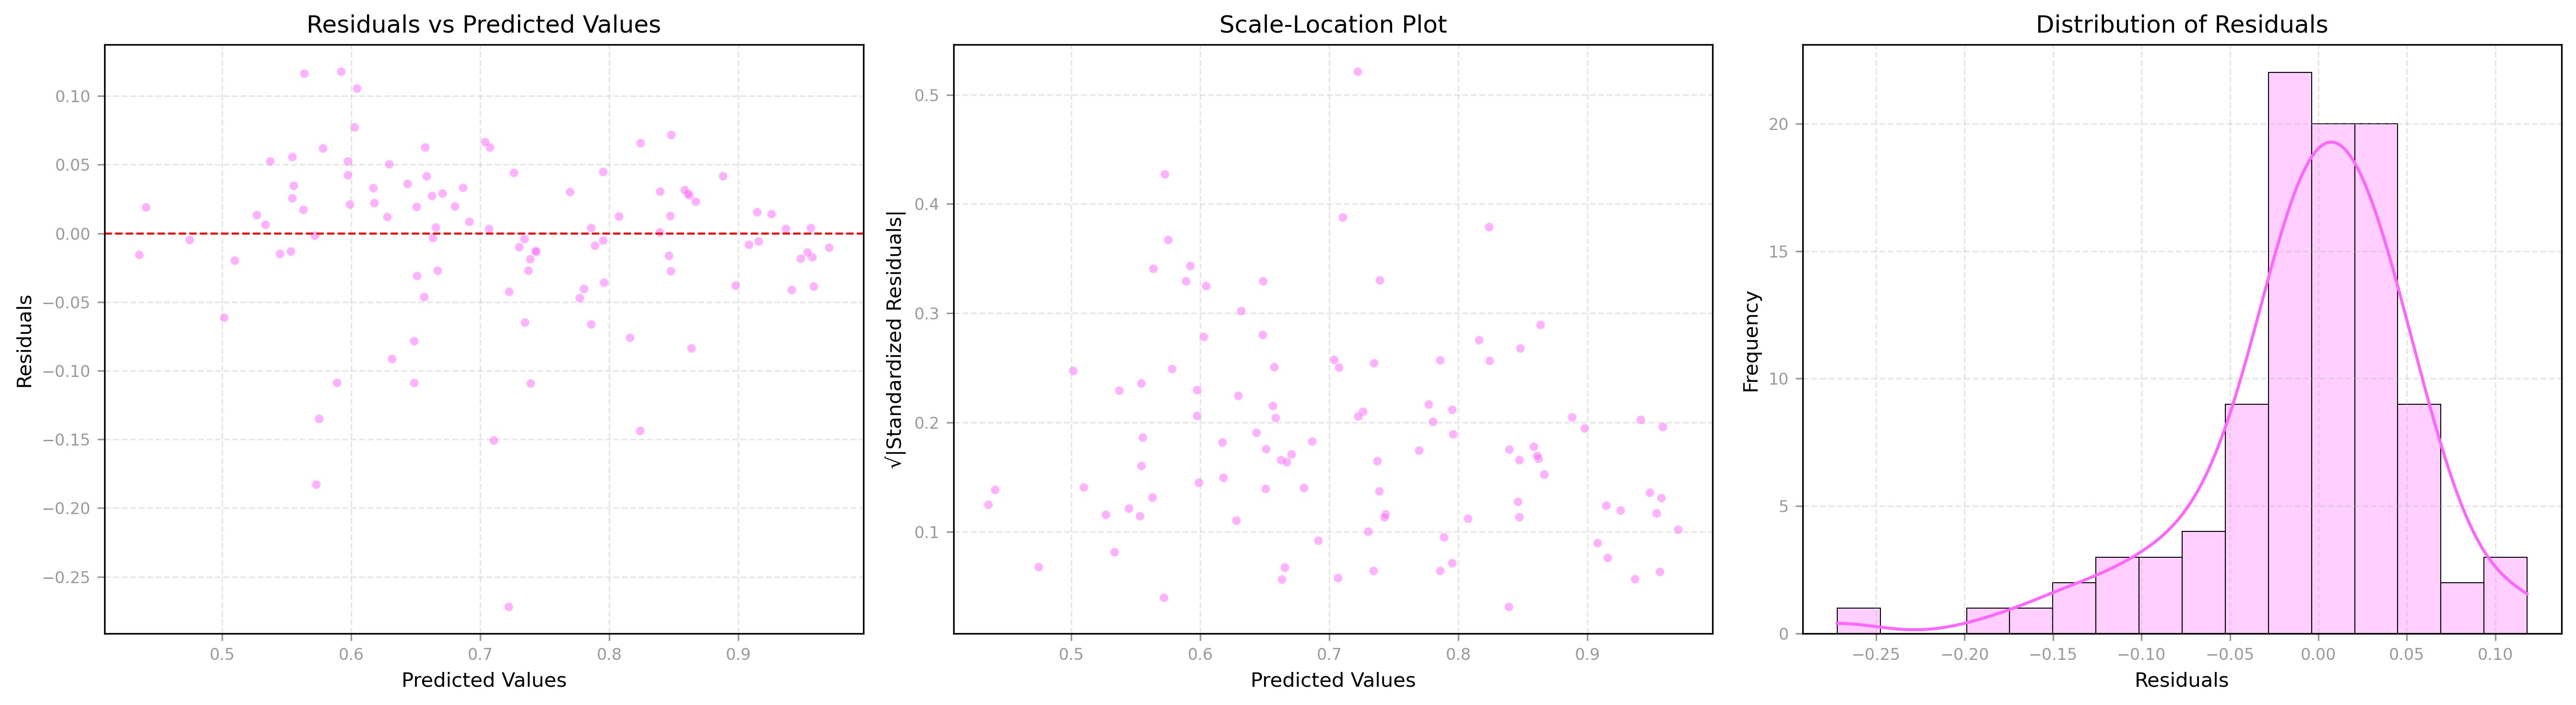

In [157]:
# Evaluate OLS Linear Regression model1 with all features 
evaluate_model_performance(model1, X_test, y_test)

<u>**Observations**</u>

LR Assumptions Check:

- **Linearity:** Appears valid; residuals randomly scattered around zero.

- **Mean of Residuals:** -0.0055 (Excellent, very close to zero).

- **Homoscedasticity:** Appears valid; Scale-Location plot shows no clear fanning.

- **Normality of Residuals:** Reasonably met; distribution is approximately bell-shaped and centered on zero.

- **Overall:** High R-squared and key OLS assumptions appear satisfied for this initial model.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

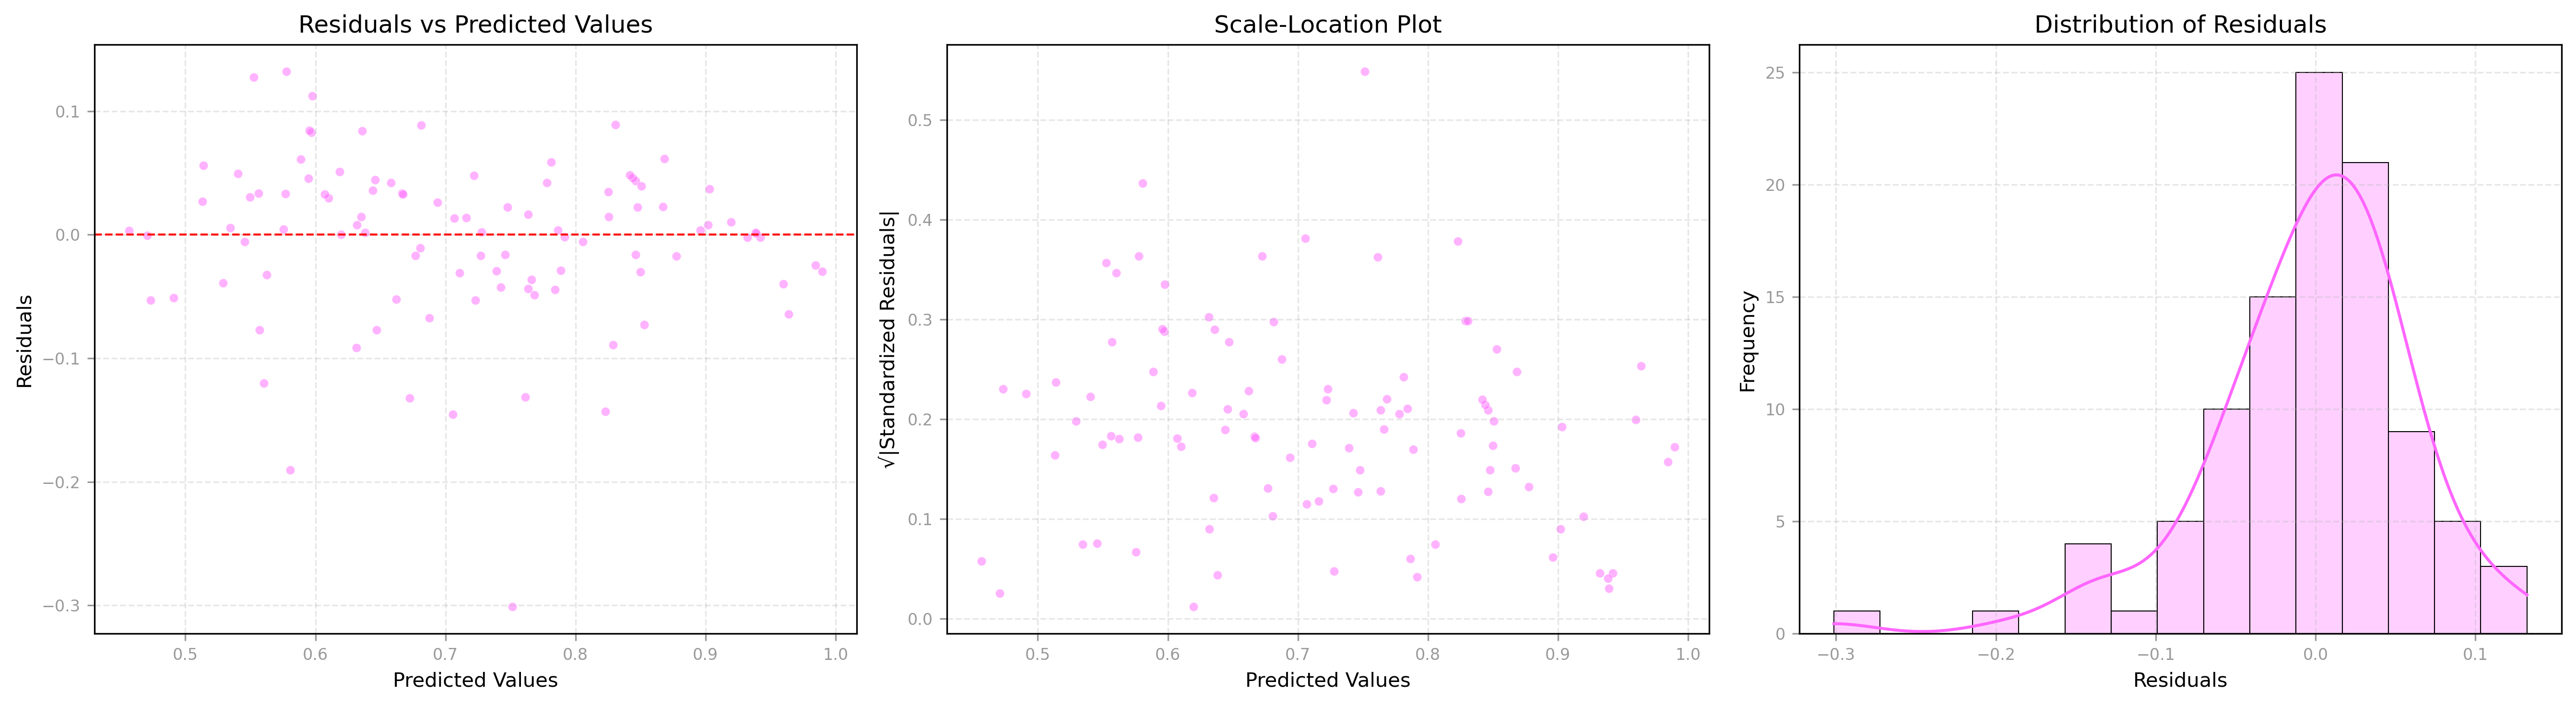

In [158]:
# Evaluate OLS Linear Regression Parsimonious Model with only two features
evaluate_model_performance(model2, X_test[parsimonious_set], y_test)

<u>**Observations**</u>

LR Assumptions Check:

- **Linearity:** Appears valid; residuals are randomly scattered around zero, no obvious pattern.

- **Mean of Residuals:** -0.0041 (Excellent, very close to zero).

- **Homoscedasticity:** Appears reasonably valid; Scale-Location plot shows a fairly random scatter, perhaps a very slight hint of increased spread at higher predicted values, but likely not a major concern.

- **Normality of Residuals:** Reasonably met; distribution is approximately bell-shaped and centered on zero. Looks very similar to the full model's residual distribution.

- **Overall:** This parsimonious model still performs well and meets OLS assumptions. There's a slight drop in R-squared and Adjusted R-squared compared to the model with all features, which is expected when removing predictors. However, it achieves this with fewer features, making it simpler. The choice between this and the full model would depend on the trade-off between a small amount of predictive power and model simplicity.

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

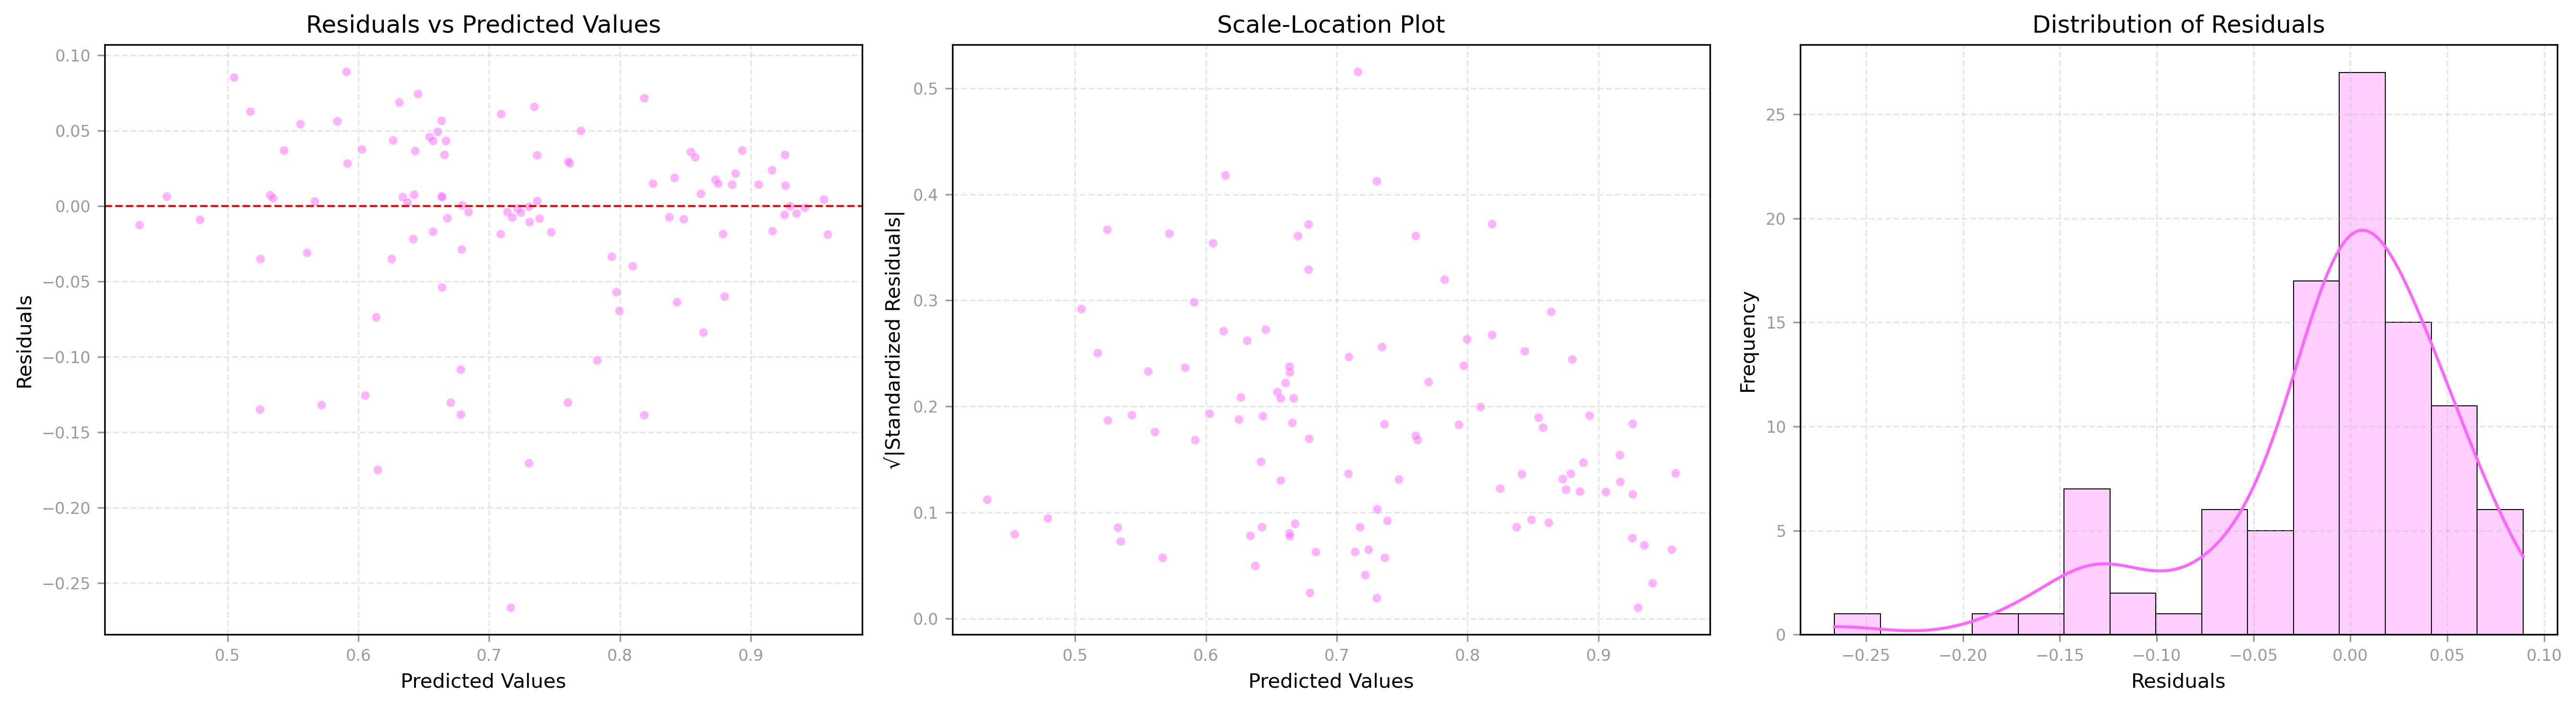

In [159]:
# Evaluate a third model with a different selection of features
set3 = ['cgpa_score', 'statement_of_purpose', 'university_rating', 'research']

evaluate_model_performance(model3, X_test[set3], y_test)

<u>**Observations**</u>

LR Assumptions Check:

- **Linearity:** Appears valid; residuals are randomly scattered around zero.

- **Mean of Residuals:** -0.0099 (Excellent, very close to zero).

- **Homoscedasticity:** Appears valid; Scale-Location plot shows a random scatter with no clear fanning.

- **Normality of Residuals:** Reasonably met; distribution is approximately bell-shaped and centered on zero. The peak seems slightly higher and narrower than previous models, but still acceptable.

- **Overall:** This model currently shows the best performance among the three evaluated, with the highest R-squared and Adjusted R-squared values, and the lowest MAE and RMSE. The OLS assumptions also appear to be well satisfied. This feature set seems to be very effective.


### **Assumptions of Linear Regression tested so far:**

✔️ Multicollinearity avoidance

✔️ Mean of Residuals

✔️ Linearity of Variables

✔️ Test for Homoscedasticity

✔️ Normality of Residuals

_____
# 8. Performance Evaluation of Various LR Models

In [160]:
def model_performance_summary(model, X_test, y_test):
    """
    Creates a summary of model performance on test data.
    
    Parameters:
    -----------
    model : fitted sklearn model object (e.g. Lasso, Ridge, LinearRegression)
    X_test : test feature matrix
    y_test : test target variable
    """
    # Get predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    n = X_test.shape[0]
    k = X_test.shape[1]
    r2 = r2_score(y_test, y_pred)
    adj_r2 = 1 - (1 - r2) * (n - 1) / (n - k - 1)
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    alpha_string = f"\\alpha={model.alpha:.4f}" if hasattr(model, 'alpha') else ""
    display(Math(f"Model: {type(model).__name__}({alpha_string})"))
    display(equation_of_line(model.coef_, model.intercept_, X_test.columns.tolist()))

    display(Math(f"R^2: {r2:.4f}\ |\ Adjusted\ R^2:\ {adj_r2:.4f}\ |\ MAE:\ {mae:.4f}\ |\ RMSE:\ {rmse:.4f}"))

## `LinearRegression()`

In [161]:
print("\n\n_____ Full Model with All Features _____")
features = X_train.columns
model = LinearRegression()
model.fit(X_train[features], y_train)
model_performance_summary(model, X_test[features], y_test)

print("\n\n_____ Parsimonious Model _____")
features = parsimonious_set
model = LinearRegression()
model.fit(X_train[features], y_train)
model_performance_summary(model, X_test[features], y_test)

print("\n\n_____ Model with Selected Features _____")
features = set3
model = LinearRegression()
model.fit(X_train[features], y_train)
model_performance_summary(model, X_test[features], y_test)



_____ Full Model with All Features _____


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>



_____ Parsimonious Model _____


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>



_____ Model with Selected Features _____


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<u>**Observations**</u>

<small>

|model|predictors|R²|Adj R²|MAE|RMSE|
|---|---|---|---|---|---|
|`LinearRegression`|`cgpa_score`, `gre_score`, `toefl_score`, `letter_of_recommendation`, `research`, `university_rating`,`statement_of_purpose`|0.8188|0.8029|0.0427|0.0609|
|`LinearRegression`|`cgpa_score`, `gre_score`|0.7912|0.7847|0.0464|0.0653|
|`LinearRegression`|`cgpa_score`, `research`, `university_rating`, `statement_of_purpose`|0.8256|0.8182|0.0405|0.0597|

</small>

## `Lasso()`

In [162]:
# Lasso Regression with various alpha values
features = X_train.columns
alphas = [0.002, 0.0088, 0.0135, 0.0205, 0.03, 0.05, 0.5]

for alpha in alphas:
    model = Lasso(alpha=alpha, fit_intercept=True, max_iter=10000)
    model.fit(X_train[features], y_train)

    # Filter out ~zero coefficients
    coef_df = pd.DataFrame({
        'Feature': features,
        'Coefficient': model.coef_
    })
    coef_df = coef_df[coef_df['Coefficient'].abs() > 1e-4]

    new_features = coef_df['Feature'].values.tolist()

    print("_____", end='')
    if len(new_features) < 2:
        display(Math(f"\\alpha={alpha}\ :\ No\ significant\ features\ found."))
        continue
    model_performance_summary(model.fit(X_train[new_features], y_train), 
                              X_test[new_features], 
                              y_test)

_____

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

_____

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

_____

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

_____

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

_____

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

_____

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

_____

<IPython.core.display.Math object>

<u>**Observations**</u>

<small>

|model|predictors|R²|Adj R²|MAE|RMSE|
|---|---|---|---|---|---|
|`Lasso(α=0.0020)`|`cgpa_score`, `gre_score`, `toefl_score`, `letter_of_recommendation`, `research`, `university_rating`, `statement_of_purpose`|0.8193|0.8056|0.0423|0.0608|
|`Lasso(α=0.0088)`|`cgpa_score`, `gre_score`, `toefl_score`, `letter_of_recommendation`, `research`, `university_rating`|0.8155|0.8036|0.0424|0.0614|
|`Lasso(α=0.0135)`|`cgpa_score`, `gre_score`, `toefl_score`, `letter_of_recommendation`, `research`|0.8081|0.7979|0.0440|0.0626|
|`Lasso(α=0.0205)`|`cgpa_score`, `gre_score`, `toefl_score`, `letter_of_recommendation`|0.7914|0.7826|0.0470|0.0653|
|`Lasso(α=0.0300)`|`cgpa_score`, `gre_score`, `toefl_score`|0.7621|0.7546|0.0518|0.0698|
|`Lasso(α=0.0500)`|`cgpa_score`, `gre_score`|0.6771|0.6704|0.0629|0.0813|
|`Lasso(α=0.5000)`|No significant features found|---|---|---|---|

</small>

_____
# 9. Actionable Insights & Recommendations

Let us consider one of the best-performing and most interpretable model with R² = 0.8256.

```Math
Model : LinearRegression()

y = 0.7242 + (0.1003*cgpa–score) + (0.0188*research) + (0.0102*university–rating) + (0.0091*statement–of–purpose)

R^2 : 0.8256 ∣ Adjusted R^2 : 0.8182 ∣ MAE: 0.0405 ∣ RMSE: 0.0597
```

Refitting the model with unscaled features, we get:

In [163]:
features = ['cgpa_score', 'research', 'university_rating', 'statement_of_purpose']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[features].reset_index(drop=True)
X_test  = X_test[features].reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

model = LinearRegression()
model.fit(X_train, y_train)
model_performance_summary(model, X_test, y_test)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

```Markdown
Chance_of_admit = -0.7892 
  + 0.1671 * `cgpa_score` 
  + 0.0378 * `research` 
  + 0.0092 * `university_rating` 
  + 0.0090 * `statement_of_purpose`
```

## **Summary Table - Model A**

| Predictor             | Impact (per unit)          | Interpretation                        |
|-----------------------|---------------------------|----------------------------------------|
| CGPA Score            | +16.71%                   | Most important, focus on academics     |
| Research Experience   | +3.78%                    | Distinct boost, seek research roles    |
| University Rating     | +0.92%                    | Better undergrad = higher chance       |
| Statement of Purpose  | +0.90%                    | Strong SOP adds value                  |

## **Insights**

1. The most-significant predictors of chance of admission are CGPA Score, Research Experience, University Rating, the strength of the student's Statement of Purpose.

2. Quantification of Impact:

    - **CGPA Score:** A 1-point increase in CGPA (on a 10-point scale) is associated with a **16.71 percentage point increase** in Chance of Admit, holding other factors constant.

    - **Research Experience:** Having research experience increases Chance of Admit by **3.78 percentage points**.

    - **University Rating:** Each 1-point increase raises Chance of Admit by **0.92 percentage points**.

    - **Statement of Purpose:** Each 1-point increase raises Chance of Admit by **0.90 percentage points**.

3. Implications for Students:

    - Academic performance (**CGPA**) is the **single most powerful lever** for improving admission chances (even more that GRE/TOEFL scores).

    - **Research experience provides a clear, independent boost**—students should seek out research or project work.

    - **Improving subjective elements** (SOP, university rating) also helps, but the effect is smaller than GPA or research.

4. The Business can consider collecting data from additional sources to potentially further enhance the Model's predictive power:

    - Quality of Undergraduate Institution
    - Undergraduate Major
    - Work Experience
    - Publications/Conference Papers
    - Interview Performance
    - Essay/Personal Statement Quality
    - Specific Program/Department Applied To
    - Number of Applications/Offers
    - Extracurriculars and Leadership

Suppose we would like **a model made up entirely of performance factors within the student's control**, we may then consider the following:

```Math
Model : Lasso(α=0.0205)

y = 0.7242 + (0.0694*cgpa–score) + (0.0256*gre–score) + (0.0113*toefl–score) + (0.0052*letter–of–recommendation)

R^2 : 0.7914 ∣ Adjusted R^2 : 0.7826 ∣ MAE: 0.0470 ∣ RMSE: 0.0653
```

Again, refitting a standard Linear Regression model with the features return by Lasso, we get:

In [164]:
features = ['cgpa_score', 'gre_score', 'toefl_score', 'letter_of_recommendation']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train[features].reset_index(drop=True)
X_test  = X_test[features].reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test  = y_test.reset_index(drop=True)

model = LinearRegression()
model.fit(X_train, y_train)
model_performance_summary(model, X_test, y_test)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

```Markdown
Chance_of_admit = -1.6382 
  + 0.1160 * `cgpa_score` 
  + 0.0192 * `letter_of_recommendation` 
  + 0.0031 * `gre_score` 
  + 0.0030 * `toefl_score`
```

## **Summary Table - Model B**

|Predictor|Impact (per unit)|Interpretation|
|---|---|---|
|CGPA Score|+11.60%|Most important, focus on academics|
|Letter of Recommendation|+1.92%|Strong LORs add meaningful value|
|GRE Score|+0.31%|Higher GRE helps, but less critical|
|TOEFL Score|+0.30%|Higher TOEFL helps, but less critical|

## **Insights**

1. Model Performance: The model displays an acceptable level of performance (R²: 0.8081)

2. Key Predictors and Their Impact

    * **CGPA Score:** A 1-point increase in CGPA (on a 10-point scale) is associated with a **11.60 percentage point increase** in Chance of Admit, holding other factors constant.

    * **Letter of Recommendation:** Each 1-point increase in LOR score (on a 1–5 scale) **increases Chance of Admit by 1.92 percentage points**.

    * **GRE Score:** Each additional point in GRE score (range: 290–340) increases Chance of Admit by **0.31 percentage points**.

    * **TOEFL Score:** Each additional point in TOEFL score (range: 90–120) increases Chance of Admit by **0.30 percentage points**.

3. Implications for Students

    * Academic performance (CGPA) is the most influential factor. Students should focus on maximizing their GPA.

    * Strong letters of recommendation provide a meaningful boost. Students should build relationships with faculty and mentors who can write impactful LORs.

    * Standardized test scores (GRE and TOEFL) matter, but their marginal impact is smaller compared to CGPA and LORs. However, optimizing these scores can still make a difference in competitive scenarios.

4. Business Recommendations

    * Prioritize support for academic excellence: Offer targeted academic counseling, GPA improvement workshops, and grade tracking.

    * LOR guidance: Provide resources and seminars on how to secure strong letters of recommendation.

    * Test preparation: Continue offering GRE/TOEFL prep, but communicate their relative impact so students can allocate effort efficiently.

_____
# 10. Conclusion

<u>**Summary Statements**</u>

1️⃣ Across multiple models, CGPA is always the most important factor, contributing between 11% and 17% of increased chance of admission per grade point. 

2️⃣ Research experience, university rating, and letters of recommendation also have positive effects, but their impact varies depending on the combination of features in the model. 

3️⃣ While each additional point in GRE or TOEFL score increases the chance of admission by only about 0.3%, the total possible contribution from these scores can be substantial—up to 15% for GRE and 9% for TOEFL across their full range. Thus, strong test scores remain an important part of a competitive application.

<small>

| Serial No. | GRE Score | TOEFL Score | Univ. Rating | SOP  | LOR  | CGPA | Research | Actual Chance | Predicted (Model A) | Predicted (Model B) |
|:----------:|:---------:|:-----------:|:------------:|:----:|:----:|:----:|:--------:|:-------------:|:-------------------:|:-------------------:|
|    121     |   335     |     117     |      5       |  5   |  5   | 9.56 |    1     |     94%      |       94%        |       96%        |
|    217     |   322     |     112     |      4       | 4.5  | 4.5  | 9.26 |    1     |     91%      |       87%        |       86%        |
|    380     |   311     |      99     |      1       | 2.5  |  3   | 8.43 |    1     |     71%      |       69%        |       66%        |
|    492     |   297     |      99     |      4       |  3   | 3.5  | 7.81 |    0     |     54%      |       58%        |       55%        |

</small>